# Effects of COVID-19 on Mental Health
######  Ritvik Prabhu 

This notebook contains research models that parses popular subreddits on mental health and analyzes the effect of COVID-19 on mental health using sentiment analysis on post headings.

---



First we begin by importing the relevant packages

In [29]:
import praw
import json
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

import urllib.request
import json 
import datetime

import numpy as np
import nltk
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from pprint import pprint
from IPython import display

import math

from psaw import PushshiftAPI

For this research, we will be using the reddit API called PRAW and sentiment analysis tool called NLTK.

We will create a method that imports client code to access the API. The data is imported from my computer for the sake of security.

In [30]:
def create_reddit_object(json_file = "reddit_config.json", json_key = "reddit_user_values"):
    with open(json_file) as f:
        data = json.load(f)
    user_values = data[json_key]
    reddit = praw.Reddit(client_id = user_values['client_id'],
client_secret = user_values['client_secret'],
user_agent = user_values['user_agent'],
username = user_values['username'],
password = user_values['password'],)
    return reddit


In [31]:
reddit = create_reddit_object()

The subreddits chosen for the research are:


</ol>

<li>r/addiction</li>
<li>r/anxiety</li>
<li>r/depression</li>
<li>r/EDAnonymous</li>
<li>r/healthanxiety</li>
<li>r/lonely</li>
<li>r/ptsd</li>
<li>r/spcialanxiety</li>
<li>r/sucidewatch</li>

</ol>

In [32]:
addiction_subreddit = reddit.subreddit('addiction')
anxiety_subreddit = reddit.subreddit('anxiety')
depression_subreddit = reddit.subreddit('depression')
EDAnonymous_subreddit = reddit.subreddit('EDAnonymous')
healthanxiety_subreddit = reddit.subreddit('healthanxiety')
lonely_subreddit = reddit.subreddit('lonely')
ptsd_subreddit = reddit.subreddit('ptsd')
socialanxiety_subreddit = reddit.subreddit('socialanxiety')
suicidewatch_subreddit = reddit.subreddit('suicidewatch')

Relevant information is filtered in each of these subreddits. The keywords include:

</ol>

<li>COVID-19</li>
<li>Coronavirus</li>
<li>Pandemic</li>
<li>Quarantine</li>
<li>isolation</li>
<li>Social distancing</li>
<li>Rona</li>
<li>Covid</li>
<li>2020</li>
<li>SARS-cov-2</li>
<li>disease</li>
<li>virus</li>
<li>sars</li>
<li>masks</li>
<li>vaccines</li>

</ol>

The keywords is supposed to cover a variety of genres under the broad canopy of COVID-19 in order to broaden the dataset. (for example, it covers genres of academia by using keywords such as "SARS-cov-2" and even social media lingo like "Rona"). The data is sorted from newest to oldest and has a time filter 'all'.

The reddit search method allows you to search for submissions and subreddits. 

Limitations:

</ol>

<li>The search terms may be sstemmed. A search for "dogs" may return results with the word "dog" in them.</li>
<li>Search results are limited to 1000 results. This limitation should change soon since Reddit is planning on allowing data dump through offline systems, as online systems get pretty backed up with traffic.(More information can be found at: <a> http://www.reddit.com/r/ideasfortheadmins/comments/10tai6/ever_wondered_the_data_liberation_policy_of_reddit/c6gicdf?context=3 </a> </li>
</ol>


Source: https://www.reddit.com/wiki/search


In [33]:
add_subreddit = addiction_subreddit.search("COVID-19 OR Coronavirus OR Pandemic OR Quarantine OR isolation OR Social distancing OR Rona OR Covid OR 2020 OR SARS-cov-2 OR disease OR virus OR sars OR masks OR vaccines", sort='new', syntax='lucene', time_filter='all', limit = 100000)
anx_subreddit = anxiety_subreddit.search("COVID-19 OR Coronavirus OR Pandemic OR Quarantine OR isolation OR Social distancing OR Rona OR Covid OR 2020 OR SARS-cov-2 OR disease OR virus OR sars OR masks OR vaccines", sort='new', syntax='lucene', time_filter='all', limit = 100000)
dep_subreddit = depression_subreddit.search("COVID-19 OR Coronavirus OR Pandemic OR Quarantine OR isolation OR Social distancing OR Rona OR Covid OR 2020 OR SARS-cov-2 OR disease OR virus OR sars OR masks OR vaccines", sort='new', syntax='lucene', time_filter='all', limit = 100000)
EDA_subreddit = EDAnonymous_subreddit.search("COVID-19 OR Coronavirus OR Pandemic OR Quarantine OR isolation OR Social distancing OR Rona OR Covid OR 2020 OR SARS-cov-2 OR disease OR virus OR sars OR masks OR vaccines", sort='new', syntax='lucene', time_filter='all', limit = 100000)
hea_subreddit = healthanxiety_subreddit.search("COVID-19 OR Coronavirus OR Pandemic OR Quarantine OR isolation OR Social distancing OR Rona OR Covid OR 2020 OR SARS-cov-2 OR disease OR virus OR sars OR masks OR vaccines", sort='new', syntax='lucene', time_filter='all', limit = 100000)
lon_subreddit = lonely_subreddit.search("COVID-19 OR Coronavirus OR Pandemic OR Quarantine OR isolation OR Social distancing OR Rona OR Covid OR 2020 OR SARS-cov-2 OR disease OR virus OR sars OR masks OR vaccines", sort='new', syntax='lucene', time_filter='all', limit = 100000)
ptsd_subreddit = ptsd_subreddit.search("COVID-19 OR Coronavirus OR Pandemic OR Quarantine OR isolation OR Social distancing OR Rona OR Covid OR 2020 OR SARS-cov-2 OR disease OR virus OR sars OR masks OR vaccines", sort='new', syntax='lucene', time_filter='all', limit = 100000)
soc_subreddit = socialanxiety_subreddit.search("COVID-19 OR Coronavirus OR Pandemic OR Quarantine OR isolation OR Social distancing OR Rona OR Covid OR 2020 OR SARS-cov-2 OR disease OR virus OR sars OR masks OR vaccines", sort='new', syntax='lucene', time_filter='all', limit = 100000)
sui_subreddit = suicidewatch_subreddit.search("COVID-19 OR Coronavirus OR Pandemic OR Quarantine OR isolation OR Social distancing OR Rona OR Covid OR 2020 OR SARS-cov-2 OR disease OR virus OR sars OR masks OR vaccines", sort='new', syntax='lucene', time_filter='all', limit = 100000)


The following 7 blocks of code creates a dataset of the data parsed

In [34]:
topics_dict_add = { "title":[], 
                "score":[], 
                "id":[], "url":[], 
                "comms_num": [], 
                "created": [], 
                "body":[]}

topics_dict_anx = { "title":[], 
                "score":[], 
                "id":[], "url":[], 
                "comms_num": [], 
                "created": [], 
                "body":[]}

topics_dict_dep = { "title":[], 
                "score":[], 
                "id":[], "url":[], 
                "comms_num": [], 
                "created": [], 
                "body":[]}

topics_dict_EDA = { "title":[], 
                "score":[], 
                "id":[], "url":[], 
                "comms_num": [], 
                "created": [], 
                "body":[]}

topics_dict_hea = { "title":[], 
                "score":[], 
                "id":[], "url":[], 
                "comms_num": [], 
                "created": [], 
                "body":[]}

topics_dict_lon = { "title":[], 
                "score":[], 
                "id":[], "url":[], 
                "comms_num": [], 
                "created": [], 
                "body":[]}

topics_dict_PTSD = { "title":[], 
                "score":[], 
                "id":[], "url":[], 
                "comms_num": [], 
                "created": [], 
                "body":[]}

topics_dict_soc = { "title":[], 
                "score":[], 
                "id":[], "url":[], 
                "comms_num": [], 
                "created": [], 
                "body":[]}

topics_dict_sui = { "title":[], 
                "score":[], 
                "id":[], "url":[], 
                "comms_num": [], 
                "created": [], 
                "body":[]}


In [35]:
for submission in add_subreddit:
    topics_dict_add["title"].append(submission.title)
    topics_dict_add["score"].append(submission.score)
    topics_dict_add["id"].append(submission.id)
    topics_dict_add["url"].append(submission.url)
    topics_dict_add["comms_num"].append(submission.num_comments)
    topics_dict_add["created"].append(submission.created)
    topics_dict_add["body"].append(submission.selftext)
    
for submission in anx_subreddit:
    topics_dict_anx["title"].append(submission.title)
    topics_dict_anx["score"].append(submission.score)
    topics_dict_anx["id"].append(submission.id)
    topics_dict_anx["url"].append(submission.url)
    topics_dict_anx["comms_num"].append(submission.num_comments)
    topics_dict_anx["created"].append(submission.created)
    topics_dict_anx["body"].append(submission.selftext)
    
for submission in dep_subreddit:
    topics_dict_dep["title"].append(submission.title)
    topics_dict_dep["score"].append(submission.score)
    topics_dict_dep["id"].append(submission.id)
    topics_dict_dep["url"].append(submission.url)
    topics_dict_dep["comms_num"].append(submission.num_comments)
    topics_dict_dep["created"].append(submission.created)
    topics_dict_dep["body"].append(submission.selftext)
    
for submission in EDA_subreddit:
    topics_dict_EDA["title"].append(submission.title)
    topics_dict_EDA["score"].append(submission.score)
    topics_dict_EDA["id"].append(submission.id)
    topics_dict_EDA["url"].append(submission.url)
    topics_dict_EDA["comms_num"].append(submission.num_comments)
    topics_dict_EDA["created"].append(submission.created)
    topics_dict_EDA["body"].append(submission.selftext)
    
for submission in hea_subreddit:
    topics_dict_hea["title"].append(submission.title)
    topics_dict_hea["score"].append(submission.score)
    topics_dict_hea["id"].append(submission.id)
    topics_dict_hea["url"].append(submission.url)
    topics_dict_hea["comms_num"].append(submission.num_comments)
    topics_dict_hea["created"].append(submission.created)
    topics_dict_hea["body"].append(submission.selftext)
    
for submission in lon_subreddit:
    topics_dict_lon["title"].append(submission.title)
    topics_dict_lon["score"].append(submission.score)
    topics_dict_lon["id"].append(submission.id)
    topics_dict_lon["url"].append(submission.url)
    topics_dict_lon["comms_num"].append(submission.num_comments)
    topics_dict_lon["created"].append(submission.created)
    topics_dict_lon["body"].append(submission.selftext)
    
for submission in ptsd_subreddit:
    topics_dict_PTSD["title"].append(submission.title)
    topics_dict_PTSD["score"].append(submission.score)
    topics_dict_PTSD["id"].append(submission.id)
    topics_dict_PTSD["url"].append(submission.url)
    topics_dict_PTSD["comms_num"].append(submission.num_comments)
    topics_dict_PTSD["created"].append(submission.created)
    topics_dict_PTSD["body"].append(submission.selftext)
    
for submission in soc_subreddit:
    topics_dict_soc["title"].append(submission.title)
    topics_dict_soc["score"].append(submission.score)
    topics_dict_soc["id"].append(submission.id)
    topics_dict_soc["url"].append(submission.url)
    topics_dict_soc["comms_num"].append(submission.num_comments)
    topics_dict_soc["created"].append(submission.created)
    topics_dict_soc["body"].append(submission.selftext)
    
for submission in sui_subreddit:
    topics_dict_sui["title"].append(submission.title)
    topics_dict_sui["score"].append(submission.score)
    topics_dict_sui["id"].append(submission.id)
    topics_dict_sui["url"].append(submission.url)
    topics_dict_sui["comms_num"].append(submission.num_comments)
    topics_dict_sui["created"].append(submission.created)
    topics_dict_sui["body"].append(submission.selftext)

In [36]:
topics_data_add = pd.DataFrame(topics_dict_add)
topics_data_anx = pd.DataFrame(topics_dict_anx)
topics_data_dep = pd.DataFrame(topics_dict_dep)
topics_data_EDA = pd.DataFrame(topics_dict_EDA)
topics_data_hea = pd.DataFrame(topics_dict_hea)
topics_data_lon = pd.DataFrame(topics_dict_lon)
topics_data_PTSD = pd.DataFrame(topics_dict_PTSD)
topics_data_soc = pd.DataFrame(topics_dict_soc)
topics_data_sui = pd.DataFrame(topics_dict_sui)

In [37]:
def get_month(created):
    return dt.datetime.fromtimestamp(created).month

In [38]:
timestamp_add = topics_data_add["created"].apply(get_month)
timestamp_anx = topics_data_anx["created"].apply(get_month)
timestamp_dep = topics_data_dep["created"].apply(get_month)
timestamp_EDA = topics_data_EDA["created"].apply(get_month)
timestamp_hea = topics_data_hea["created"].apply(get_month)
timestamp_lon = topics_data_lon["created"].apply(get_month)
timestamp_PTSD = topics_data_PTSD["created"].apply(get_month)
timestamp_soc = topics_data_soc["created"].apply(get_month)
timestamp_sui = topics_data_sui["created"].apply(get_month)

In [39]:
topics_data_add = topics_data_add.assign(timestamp = timestamp_add)
topics_data_anx = topics_data_anx.assign(timestamp = timestamp_anx)
topics_data_dep = topics_data_dep.assign(timestamp = timestamp_dep)
topics_data_EDA = topics_data_EDA.assign(timestamp = timestamp_EDA)
topics_data_hea = topics_data_hea.assign(timestamp = timestamp_hea)
topics_data_lon = topics_data_lon.assign(timestamp = timestamp_lon)
topics_data_PTSD = topics_data_PTSD.assign(timestamp = timestamp_PTSD)
topics_data_soc = topics_data_soc.assign(timestamp = timestamp_soc)
topics_data_sui = topics_data_sui.assign(timestamp = timestamp_sui)

Example of the data collected from **r/anxiety**

In [40]:
topics_data_anx.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Another week of anxiety ahead... how to keep c...,1,k9ux40,https://www.reddit.com/r/Anxiety/comments/k9ux...,0,1.607560e+09,"So I’m a 26 year old male. On 4th November, a ...",12
1,Social Anxiety,1,k9undj,https://www.reddit.com/r/Anxiety/comments/k9un...,0,1.607559e+09,So I used to have really bad social anxiety bu...,12
2,Just Called Out of Work - I’m Not Sure What to...,1,k9u9vl,https://www.reddit.com/r/Anxiety/comments/k9u9...,5,1.607558e+09,Last Friday night while watching TV with my fi...,12
3,Anxiety is driving me crazy!!!,1,k9tojr,https://www.reddit.com/r/Anxiety/comments/k9to...,0,1.607556e+09,So I’ve always had OCD and anxiety issues sinc...,12
4,Jaw tension in social settings?,1,k9sv7r,https://www.reddit.com/r/Anxiety/comments/k9sv...,1,1.607553e+09,"I’m not sure why, but recently whenever I am i...",12


The following 4 blocks of code calculate the total number of posts from all the aforementioned subreddits. Since there are not a lot of data that I have access to, the data depicted is limited and does not depict the true nature of the research

In [41]:
def month_total(df):
    dict = {}
    for i in df['timestamp']:
        dict[i] = (df['timestamp'] == i).sum()
    month_list = dict.keys() 
    value_list = dict.values()
    return [list(month_list), list(value_list)]

In [42]:
dict = {'Sep':0, 'Oct':0, 'Nov':0}
sub = [topics_data_add, topics_data_anx, topics_data_dep, topics_data_EDA, topics_data_hea, topics_data_lon, topics_data_PTSD, topics_data_soc, topics_data_sui]

In [43]:
for i in sub:
    for j in range(len(month_total(i)[0])):
        if month_total(i)[0][j] == 11:
            dict['Nov']+= month_total(i)[1][j]
        elif month_total(i)[0][j] == 10:
            dict['Oct']+= month_total(i)[1][j]
        elif month_total(i)[0][j] == 9:
            dict['Sep']+=  month_total(i)[1][j]

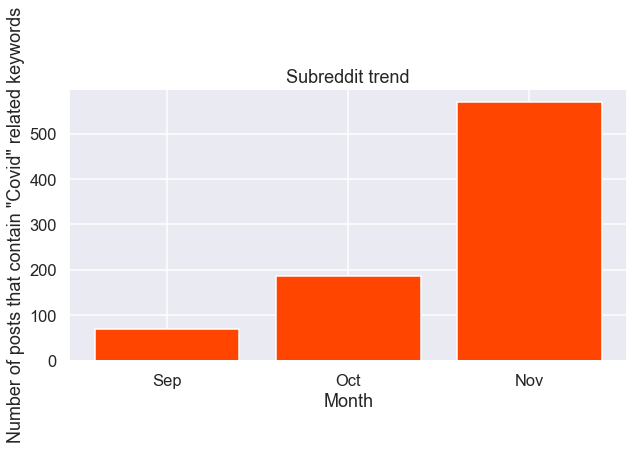

In [44]:
fig, ax = plt.subplots(figsize = (10,5))
plt.bar(dict.keys(), dict.values(), color='orangered')

ax.set_ylabel('Number of posts that contain "Covid" related keywords')
ax.set_xlabel('Month')
ax.set_title('Subreddit trend')
plt.show()

Since the results from parsing through specific subreddits led to inconclusive results, we are going to parse through the most popular subreddit for the Coronavirus - "COVID19" - in order to assess the positive, negative and neutral sentiments of the subreddit.

Vader lexicon and stop words are downloaded from NLTK. Vader lexicon is a sentiment analysis tool that specifically attuned to sentiments expressed in social media. (https://www.kaggle.com/nltkdata/vader-lexicon)

In [45]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ritvi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ritvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
sns.set(style='darkgrid', context='talk', palette='Dark2')

The data from COVID19 is pulled and this data is iterated through to obtain the headlines of each post pulled.

In [47]:
headlines = {}
for sub in reddit.subreddit('COVID19').new(limit=None):
    headlines[sub.title] = sub.created

Using sentiment analyzer we will label the data as positive, negative and neutral. We iterate through the lines and use the polarity_scores method to get the sentiment score. This data is ultimately added to a data frame.

In [48]:
sia = SIA()
results = []
for line in list(headlines.keys()):
    scores = sia.polarity_scores(line)
    scores['headline'] = line
    scores['created'] = headlines[line]    
    results.append(scores)
df = pd.DataFrame.from_records(results)
df.head()

,neg,neu,pos,compound,headline,created
0,0.0,1.0,0.0,0.0,The FDA Weighs Its First Coronavirus Vaccine,1.607559e+09
1,0.0,1.0,0.0,0.0,Regulatory Decision Summary - Pfizer-BioNTech ...,1.607559e+09
2,0.0,1.0,0.0,0.0,Anti-SARS-CoV-2 activity of Andrographis panic...,1.607555e+09
3,0.0,1.0,0.0,0.0,Extended in vitro inactivation of SARS-CoV-2 b...,1.607555e+09
4,0.0,1.0,0.0,0.0,Binding of SARS-CoV-2 spike protein to ACE2 is...,1.607555e+09


We label the data with compound value greater than 0.1 as positive and less than -0.1 as negative. This value was attained after some level of trial and error.

In [49]:
df['label'] = 0
df.loc[df['compound']>0.1, 'label'] = 1
df.loc[df['compound']<-0.1, 'label'] = -1

Here is a list of examples of positive, negative and neutral headlines. As you can see, it does not do very well. In certain cases, it would even consider testing **positive** for the virus as a good thing, when in reality it is not. This is another limitation that we have run into.

In [50]:
print("positive headlines: \n")
pprint(list(df[df['label'] == 1].headline)[:5],width = 100)

print("\n neagtive headlines: \n")
pprint(list(df[df['label'] == -1].headline)[:5],width = 100)

print("\n neutral headlines: \n")
pprint(list(df[df['label'] == 0].headline)[:5],width = 100)

positive headlines: 

['Significant inactivation of SARS-CoV-2 by a green tea catechin, a catechin-derivative and '
 'galloylated theaflavins in vitro',
 'Safety and efficacy of the ChAdOx1 nCoV-19 vaccine (AZD1222) against SARS-CoV-2: an interim '
 'analysis of four randomised controlled trials in Brazil, South Africa, and the UK',
 'Evaluation of SARS-CoV-2 neutralization assays for antibody monitoring in natural infection and '
 'vaccine trials',
 'The UK RECOVERY trial: An ambitious test of COVID-19 treatments',
 'Metabolic reprogramming and epigenetic changes of vital organs in SARS-CoV-2 induced systemic '
 'toxicity']

 neagtive headlines: 

['Healthcare workers 7 times as likely to have severe COVID-19 as other workers',
 'Occupation and risk of severe COVID-19: prospective cohort study of 120 075 UK Biobank '
 'participants',
 'Schools Closures during the COVID-19 Pandemic: A Catastrophic Global Situation',
 'Three-quarters attack rate of SARS-CoV-2 in the Brazilian Amazon dur

We now do some statistical testing. The first set of numbers below show the number of posts that the sentiment analyzer deems positive, negative and neutral. The second set of outputs is the percentage of positive, negative and neutral posts.

In [51]:
print(df.label.value_counts())
print(df.label.value_counts(normalize = True)*100)

 0    478
-1    195
 1    191
Name: label, dtype: int64
 0    55.324074
-1    22.569444
 1    22.106481
Name: label, dtype: float64


The below graph is a graphical representation of the percentage values of the positive, negative and neutral posts

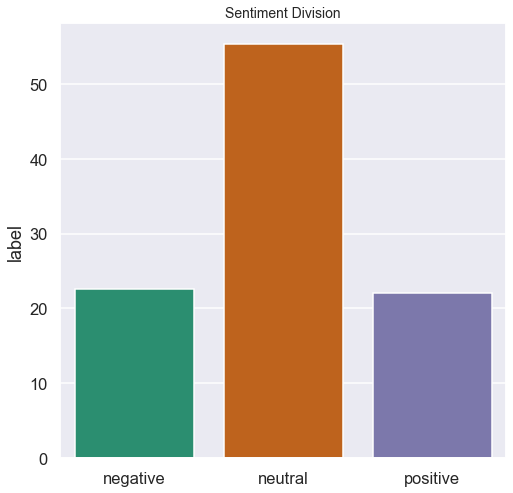

In [52]:
fig, ax = plt.subplots(figsize = (8,8))
counts = df.label.value_counts(normalize=True)*100
labels = (['negative', 'neutral' ,'positive'])
sns.barplot(x=counts.index, y= counts, ax=ax)
ax.set_xticklabels(labels)
plt.title("Sentiment Division", fontsize=14)
plt.show()

As you can see, the results here are not only biased but also non-conclusive.


## Conclusion

In conclusion, because of the bias in data, lack of access to data and the limitations of the NLP tool performing a sentiment analysis on medical terminology, the results of this research is inconclusive.

<hr>

### Additional Information

We are going to analyze the most common words in COVID19

We import the necessary packages. We keep in mind that our data needs to be free from any stop words and punctuation, hence we normalize our data.

In [53]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
tokenizer = RegexpTokenizer(r'\w+')

In [54]:
stop_words = stopwords.words('english')
def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        for i in toks:
            tokens.append(i)
    return tokens

The data below shows the most common words from all of the posts.

In [55]:
pos_lines = list(df[df.label == 0].headline)
pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)
pos_freq.most_common(10)

[('covid', 262),
 ('19', 252),
 ('2', 200),
 ('sars', 198),
 ('cov', 192),
 ('patients', 57),
 ('infection', 48),
 ('study', 40),
 ('vaccine', 39),
 ('coronavirus', 33)]

As we can see, this data indicates that the sentiment should be a bit more neutral. This is reflected by the sentiment analyzer. While the sentiment analyzer is slightly accurate, there are clear examples shown above that prove otherwise.

---